In [1]:
# Let's start simple with a LocalCluster that makes use of all the cores and RAM we have on a single machine
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
# explicitly connect to the cluster we just created
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:41157 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 67.15 GB


In [2]:
# Although this is small csv file, we'll reuse our same example from before!
# Load csv results from server into a Pandas DataFrame
import dask.dataframe as dd
server = 'https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?'
query = 'service=WFS&version=2.0.0&request=GetFeature&typeName=GVP-VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv'

# blocksize=None means use a single partion
df = dd.read_csv(server+query, blocksize=None)
# We only see the metadata, the actual data are only computed when requested.
df

,FID,Volcano_Number,Volcano_Name,Primary_Volcano_Type,Last_Eruption_Year,Country,Geological_Summary,Region,Subregion,Latitude,Longitude,Elevation,Tectonic_Setting,Geologic_Epoch,Evidence_Category,Primary_Photo_Link,Primary_Photo_Caption,Primary_Photo_Credit,Major_Rock_Type,GeoLocation
npartitions=1,,,,,,,,,,,,,,,,,,,,
,object,int64,object,object,float64,object,object,object,object,float64,float64,int64,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [3]:
# We can break up the table into 4 partions to map out to each core:
df = df.repartition(npartitions=4)
df

,FID,Volcano_Number,Volcano_Name,Primary_Volcano_Type,Last_Eruption_Year,Country,Geological_Summary,Region,Subregion,Latitude,Longitude,Elevation,Tectonic_Setting,Geologic_Epoch,Evidence_Category,Primary_Photo_Link,Primary_Photo_Caption,Primary_Photo_Credit,Major_Rock_Type,GeoLocation
npartitions=4,,,,,,,,,,,,,,,,,,,,
,object,int64,object,object,float64,object,object,object,object,float64,float64,int64,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [4]:
# Let's say we want to know the minimum last eruption year for all volcanoes
last_eruption_year_min = df.Last_Eruption_Year.min()
last_eruption_year_min

dd.Scalar<series-..., dtype=float64>

In [5]:
# To get the value call the 'compute method'
# NOTE: this was slower than using pandas directly,,, for small data you often don't need to use parallel computing!
last_eruption_year_min.compute()

-10450.0

In [6]:
import numpy as np
shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [7]:
print('%.1f MB' % (ones_np.nbytes / 1e6))

32.0 MB


In [8]:
import dask.array as da
ones = da.ones(shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

In [9]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [10]:
#Notice that we just see a symbolic representation of the array, including its shape, dtype, and chunksize. No data has been generated yet. When we call .compute() on a dask array, the computation is trigger and the dask array becomes a numpy array.
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [11]:
bigshape = (200000, 4000)
big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones

dask.array<ones, shape=(200000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [12]:
print('%.1f MB' % (big_ones.nbytes / 1e6))

6400.0 MB


In [20]:
big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

%time result = big_calc.compute()
result

CPU times: user 1.1 s, sys: 73.3 ms, total: 1.17 s
Wall time: 1.33 s


1.0

In [21]:
big_np_ones = np.ones(bigshape)
%time result = (big_np_ones * big_np_ones[::-1, ::-1]).mean()
result

CPU times: user 2.31 s, sys: 1.1 s, total: 3.41 s
Wall time: 3.17 s


1.0

In [22]:
%time big_ones_reduce = (np.cos(big_ones)**2).mean(axis=1)
big_ones_reduce

CPU times: user 11.1 ms, sys: 4.49 ms, total: 15.6 ms
Wall time: 14.5 ms


dask.array<mean_agg-aggregate, shape=(200000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

In [23]:
%time big_np_ones_reduce = (np.cos(big_np_ones)**2).mean(axis=1)
big_np_ones_reduce

CPU times: user 12.6 s, sys: 1.6 s, total: 14.2 s
Wall time: 13.5 s


array([0.29192658, 0.29192658, 0.29192658, ..., 0.29192658, 0.29192658,
       0.29192658])

In [24]:
import numpy as np
import xarray as xr

In [25]:
print('Numpy version: ', np.__version__)
print('Xarray version: ', xr.__version__)

Numpy version:  1.20.1
Xarray version:  0.17.0


In [26]:
x = np.linspace(-np.pi, np.pi, 19)
f = np.sin(x)

In [27]:
da_f = xr.DataArray(f)
da_f

<xarray.DataArray (dim_0: 19)>
array([-1.22464680e-16, -3.42020143e-01, -6.42787610e-01, -8.66025404e-01,
       -9.84807753e-01, -9.84807753e-01, -8.66025404e-01, -6.42787610e-01,
       -3.42020143e-01,  0.00000000e+00,  3.42020143e-01,  6.42787610e-01,
        8.66025404e-01,  9.84807753e-01,  9.84807753e-01,  8.66025404e-01,
        6.42787610e-01,  3.42020143e-01,  1.22464680e-16])
Dimensions without coordinates: dim_0

In [28]:
da_f = xr.DataArray(f, dims=['x'])
da_f

<xarray.DataArray (x: 19)>
array([-1.22464680e-16, -3.42020143e-01, -6.42787610e-01, -8.66025404e-01,
       -9.84807753e-01, -9.84807753e-01, -8.66025404e-01, -6.42787610e-01,
       -3.42020143e-01,  0.00000000e+00,  3.42020143e-01,  6.42787610e-01,
        8.66025404e-01,  9.84807753e-01,  9.84807753e-01,  8.66025404e-01,
        6.42787610e-01,  3.42020143e-01,  1.22464680e-16])
Dimensions without coordinates: x

In [29]:
da_f = xr.DataArray(f, dims=['x'], coords={'x': x})
da_f

<xarray.DataArray (x: 19)>
array([-1.22464680e-16, -3.42020143e-01, -6.42787610e-01, -8.66025404e-01,
       -9.84807753e-01, -9.84807753e-01, -8.66025404e-01, -6.42787610e-01,
       -3.42020143e-01,  0.00000000e+00,  3.42020143e-01,  6.42787610e-01,
        8.66025404e-01,  9.84807753e-01,  9.84807753e-01,  8.66025404e-01,
        6.42787610e-01,  3.42020143e-01,  1.22464680e-16])
Coordinates:
  * x        (x) float64 -3.142 -2.793 -2.443 -2.094 ... 2.094 2.443 2.793 3.142

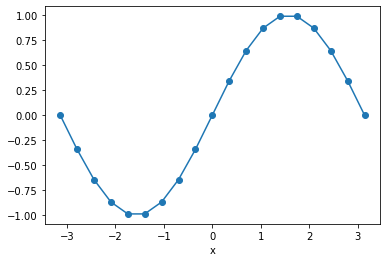

In [30]:
da_f.plot(marker='o')

In [31]:
# get the first 10 items
da_f[:10]

<xarray.DataArray (x: 10)>
array([-1.22464680e-16, -3.42020143e-01, -6.42787610e-01, -8.66025404e-01,
       -9.84807753e-01, -9.84807753e-01, -8.66025404e-01, -6.42787610e-01,
       -3.42020143e-01,  0.00000000e+00])
Coordinates:
  * x        (x) float64 -3.142 -2.793 -2.443 -2.094 ... -0.6981 -0.3491 0.0

In [32]:
da_f.sel(x=0)

<xarray.DataArray ()>
array(0.)
Coordinates:
    x        float64 0.0

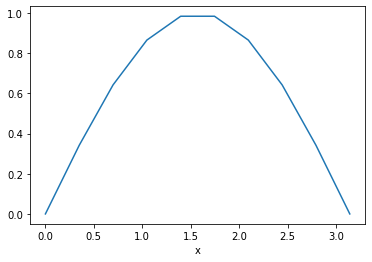

In [33]:
da_f.sel(x=slice(0, np.pi)).plot()

In [34]:
da_g = da_f**2 + 1
da_g

<xarray.DataArray (x: 19)>
array([1.        , 1.11697778, 1.41317591, 1.75      , 1.96984631,
       1.96984631, 1.75      , 1.41317591, 1.11697778, 1.        ,
       1.11697778, 1.41317591, 1.75      , 1.96984631, 1.96984631,
       1.75      , 1.41317591, 1.11697778, 1.        ])
Coordinates:
  * x        (x) float64 -3.142 -2.793 -2.443 -2.094 ... 2.094 2.443 2.793 3.142

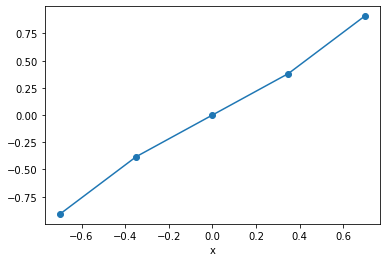

In [35]:
(da_f * da_g).sel(x=slice(-1, 1)).plot(marker='o')

In [36]:
%%bash

git clone https://github.com/pangeo-data/tutorial-data.git

Cloning into 'tutorial-data'...


In [37]:
ds = xr.open_dataset('./tutorial-data/sst/NOAA_NCDC_ERSST_v3b_SST-1960.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 12)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 1960-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [38]:
## Xarray > v0.14.1 has a new HTML output type!
xr.set_options(display_style="html")
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 12)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 1960-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [39]:
# both do the exact same thing

# dictionary syntax
sst = ds['sst']

# attribute syntax
sst = ds.sst

sst

<xarray.DataArray 'sst' (time: 12, lat: 89, lon: 180)>
[192240 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 1960-12-15
Attributes:
    pointwidth:          1.0
    valid_min:           -3.0
    valid_max:           45.0
    units:               degree_Celsius
    long_name:           Extended reconstructed sea surface temperature
    standard_name:       sea_surface_temperature
    iridl:hasSemantics:  iridl:SeaSurfaceTemperature

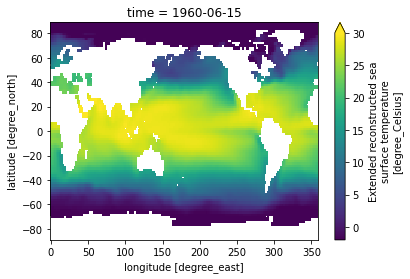

In [40]:
sst.sel(time='1960-06-15').plot(vmin=-2, vmax=30)

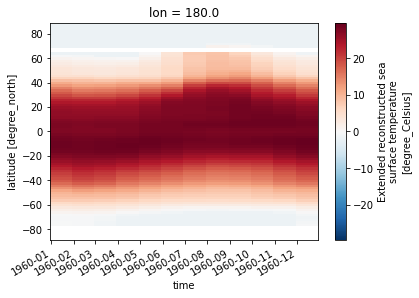

In [41]:
sst.sel(lon=180).transpose().plot()

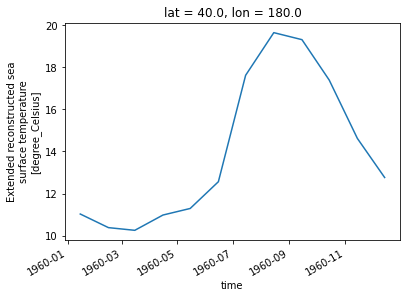

In [42]:
sst.sel(lon=180, lat=40).plot()

In [43]:
sst.mean()

<xarray.DataArray 'sst' ()>
array(13.626506, dtype=float32)

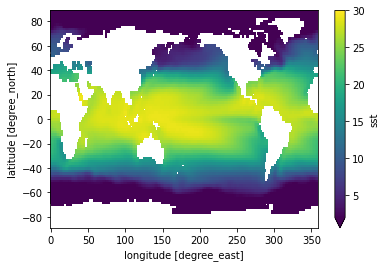

In [45]:
sst.mean(dim='time').plot(vmin=2,vmax=30)

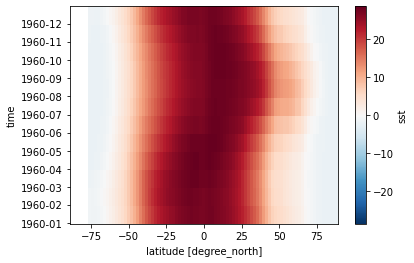

In [46]:
sst.mean(dim='lon').plot()

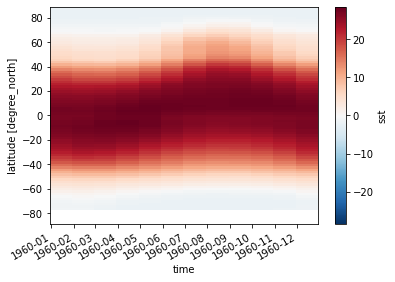

In [50]:
sst_zonal_mean = sst.mean(dim='lon')
sst_zonal_mean.transpose().plot()

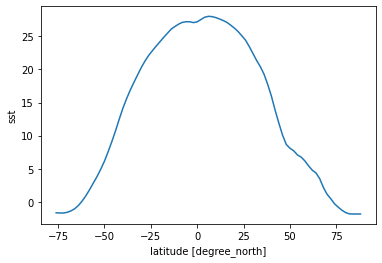

In [51]:
sst.mean(dim=('time', 'lon')).plot()

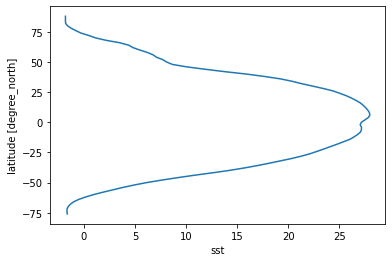

In [52]:
sst.mean(dim=('time', 'lon')).plot(y='lat')

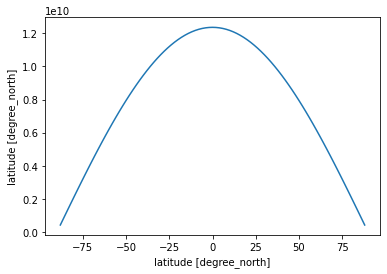

In [53]:
R = 6.37e6
# we know already that the spacing of the points is one degree latitude
dϕ = np.deg2rad(1.)
dλ = np.deg2rad(1.)
dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat))
dA.plot()

In [58]:
dA

<xarray.DataArray 'lat' (lat: 89)>
array([4.3137274e+08, 8.6222048e+08, 1.2920163e+09, 1.7202395e+09,
       2.1463668e+09, 2.5698775e+09, 2.9902589e+09, 3.4069972e+09,
       3.8195827e+09, 4.2275164e+09, 4.6302991e+09, 5.0274396e+09,
       5.4184566e+09, 5.8028713e+09, 6.1802148e+09, 6.5500303e+09,
       6.9118648e+09, 7.2652785e+09, 7.6098412e+09, 7.9451310e+09,
       8.2707420e+09, 8.5862769e+09, 8.8913500e+09, 9.1855903e+09,
       9.4686392e+09, 9.7401528e+09, 9.9997983e+09, 1.0247262e+10,
       1.0482239e+10, 1.0704446e+10, 1.0913612e+10, 1.1109481e+10,
       1.1291815e+10, 1.1460392e+10, 1.1615006e+10, 1.1755469e+10,
       1.1881608e+10, 1.1993273e+10, 1.2090326e+10, 1.2172647e+10,
       1.2240139e+10, 1.2292720e+10, 1.2330322e+10, 1.2352901e+10,
       1.2360431e+10, 1.2352901e+10, 1.2330322e+10, 1.2292720e+10,
       1.2240139e+10, 1.2172647e+10, 1.2090326e+10, 1.1993273e+10,
       1.1881608e+10, 1.1755469e+10, 1.1615006e+10, 1.1460392e+10,
       1.1291815e+10, 1.1109481e+10, 1.0913612e+10, 1.0704446e+10,
       1.0482239e+10, 1.0247262e+10, 9.9997983e+09, 9.7401528e+09,
       9.4686392e+09, 9.1855903e+09, 8.8913500e+09, 8.5862769e+09,
       8.2707420e+09, 7.9451310e+09, 7.6098412e+09, 7.2652785e+09,
       6.9118648e+09, 6.5500303e+09, 6.1802148e+09, 5.8028713e+09,
       5.4184566e+09, 5.0274396e+09, 4.6302991e+09, 4.2275164e+09,
       3.8195827e+09, 3.4069972e+09, 2.9902589e+09, 2.5698775e+09,
       2.1463668e+09, 1.7202395e+09, 1.2920163e+09, 8.6222048e+08,
       4.3137274e+08], dtype=float32)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
Attributes:
    standard_name:  latitude
    pointwidth:     2.0
    gridtype:       0
    units:          degree_north

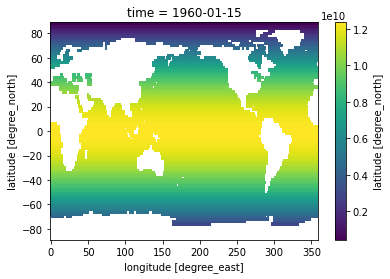

In [59]:
pixel_area = dA.where(sst[0].notnull())
pixel_area.plot()

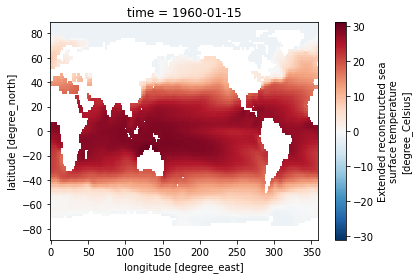

In [60]:
sst[0].plot()

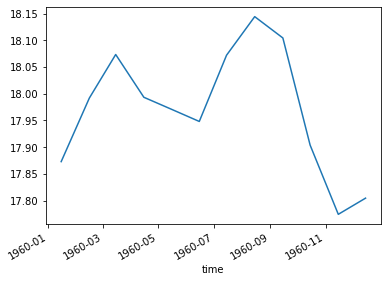

In [61]:
total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
sst_weighted_mean = (sst * pixel_area).sum(dim=('lon', 'lat')) / total_ocean_area
sst_weighted_mean.plot()

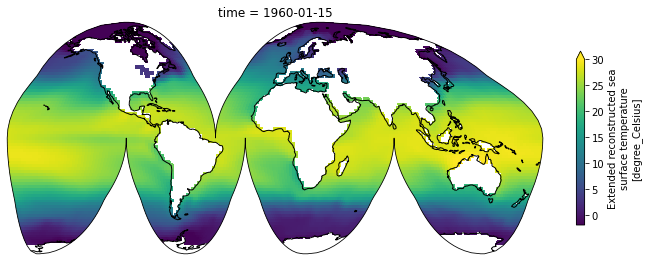

In [62]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.InterruptedGoodeHomolosine())
ax.coastlines()

sst[0].plot(transform=ccrs.PlateCarree(), vmin=-2, vmax=30,
            cbar_kwargs={'shrink': 0.4})

In [63]:
ds_all = xr.open_mfdataset('./tutorial-data/sst/*nc', combine='by_coords')
ds_all

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(12, 89, 180), meta=np.ndarray>
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [64]:
sst_clim = ds_all.sst.groupby('time.month').mean(dim='time')
sst_clim

<xarray.DataArray 'sst' (month: 12, lat: 89, lon: 180)>
dask.array<stack, shape=(12, 89, 180), dtype=float32, chunksize=(1, 89, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

Text(0.5, 1.0, 'June minus July SST Climatology')

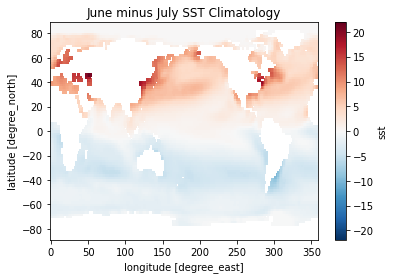

In [65]:
(sst_clim[6] - sst_clim[0]).plot()
plt.title('June minus July SST Climatology')

In [66]:
sst_ts = ds_all.sst.sel(lon=300, lat=10)
sst_ts_annual = sst_ts.resample(time='A').mean(dim='time')
sst_ts_annual

<xarray.DataArray 'sst' (time: 57)>
dask.array<stack, shape=(57,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1960-12-31 1961-12-31 ... 2016-12-31
    lat      float32 10.0
    lon      float32 300.0

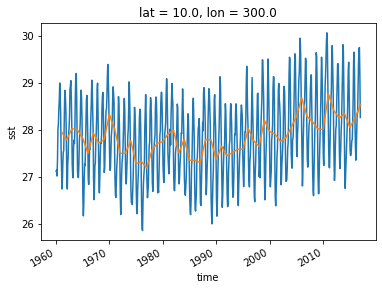

In [67]:
sst_ts.plot()
sst_ts_annual.plot()

In [68]:
sst_ts

<xarray.DataArray 'sst' (time: 684)>
dask.array<getitem, shape=(684,), dtype=float32, chunksize=(12,), chunktype=numpy.ndarray>
Coordinates:
    lat      float32 10.0
    lon      float32 300.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Attributes:
    pointwidth:          1.0
    valid_min:           -3.0
    valid_max:           45.0
    units:               degree_Celsius
    long_name:           Extended reconstructed sea surface temperature
    standard_name:       sea_surface_temperature
    iridl:hasSemantics:  iridl:SeaSurfaceTemperature

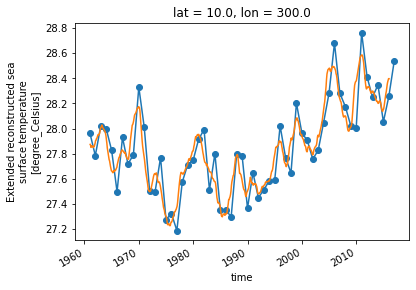

In [69]:
sst_ts_rolling = sst_ts.rolling(time=24, center=True).mean()
sst_ts_annual.plot(marker='o')
sst_ts_rolling.plot()